In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


R squared for top charge: 0.10805974592335277
intercept for top charge: -16420.543435165913
coefficients for top charge: [  8.21163043 -10.22191358  -8.60778738   4.92181772  -0.21964202
   8.57012989   1.46469865  -1.99732883  -4.90015251 -21.26005783
  -8.12820695  15.69327511  20.59247101   4.32401045   2.19268974
  -2.80724072  -1.27343249  -0.17669349  -2.25933347]
-----------------------------
R squared for age: 0.17142627747897587
intercept for age: 2799.3533362411968
coefficients for age: [-1.3608937  -3.70932511  0.6007257   0.68965126 -6.4066428  -0.01272904
 -3.31272321 -3.18025246  3.79092536 -2.84999762  3.89887976  0.25103326
 -1.91058831 -0.22988084 -0.56523685  2.62036138 -2.02287603 -0.69768345
  0.89531579]


Text(510.4494949494949, 0.5, 'Predicted age')

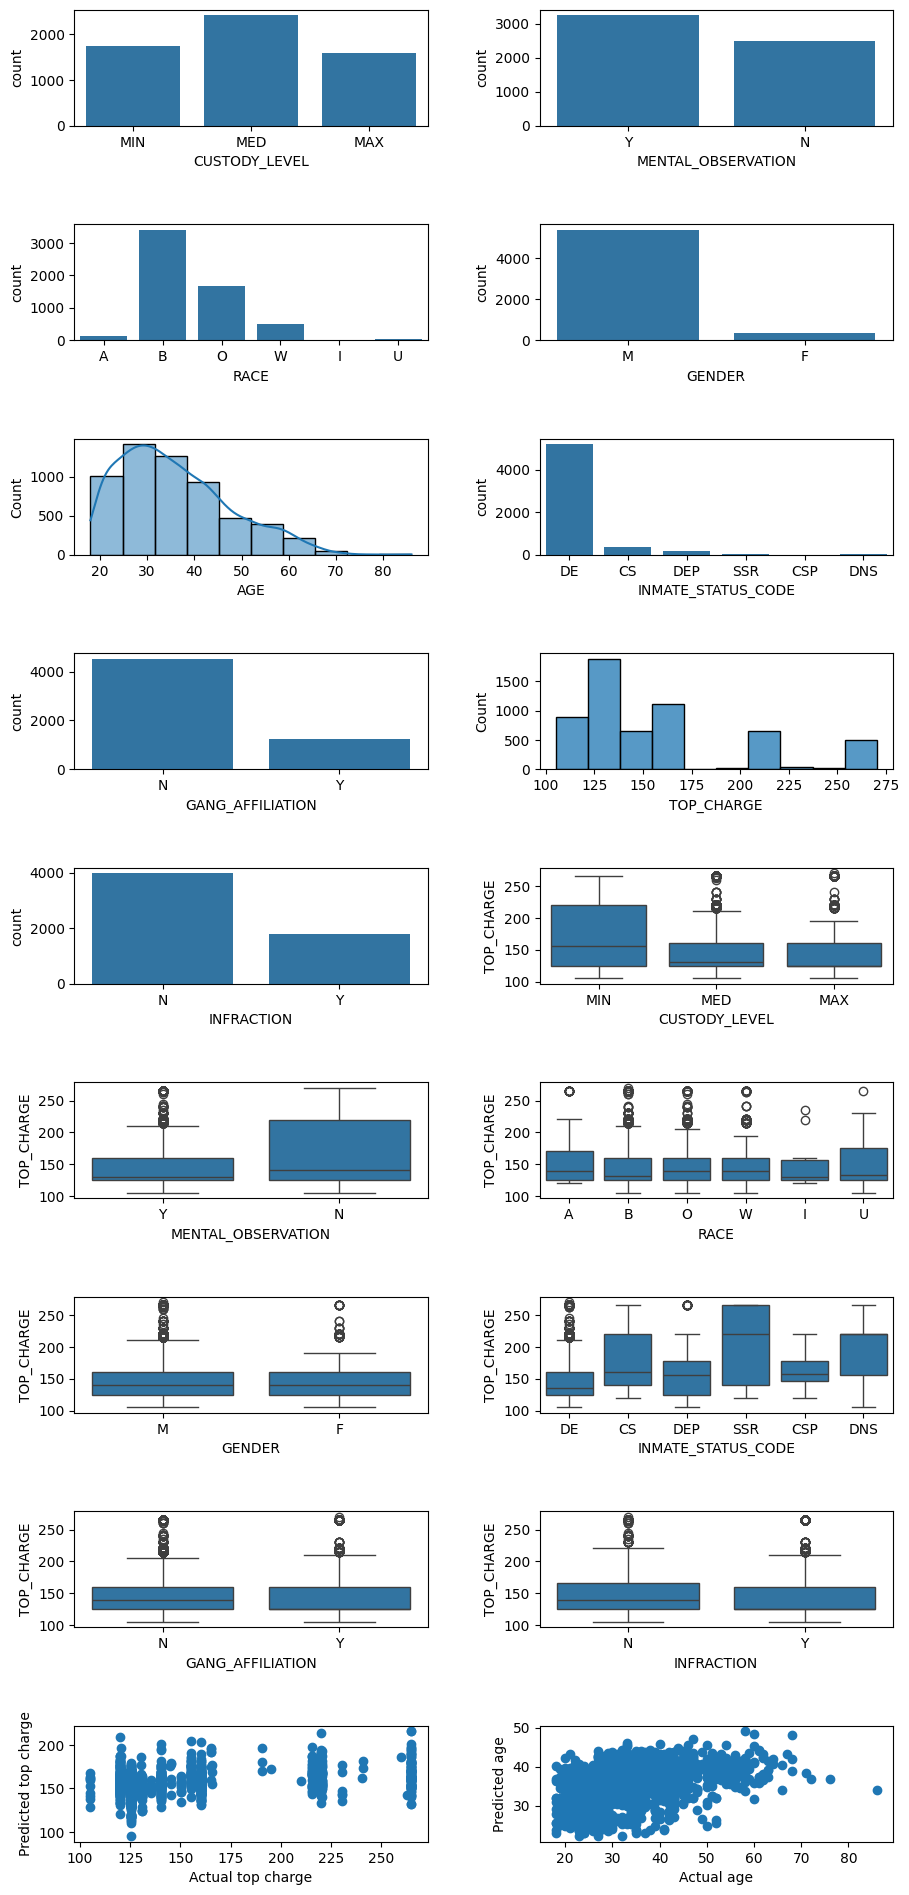

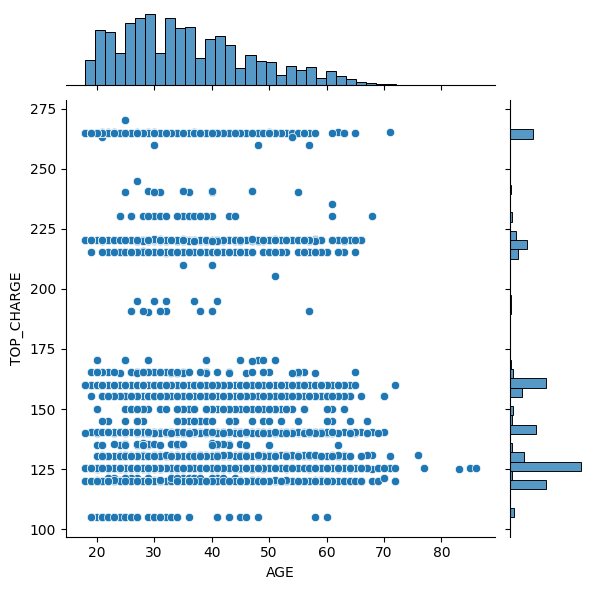

In [9]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt
import seaborn as sns
#https://data.cityofnewyork.us/Public-Safety/Daily-Inmates-In-Custody/7479-ugqb/about_data
path="/content/drive/MyDrive/Spring 2024/CS301/Dataset/Inmates.csv"
data = pd.read_csv(path)
pd.options.mode.chained_assignment = None

#PREPROCESSING
#----------------------------------------------------------------------------------------------------
#Rename columns
data.rename(columns = {'BRADH':'MENTAL_OBSERVATION'}, inplace = True)
data.rename(columns = {'SRG_FLG':'GANG_AFFILIATION'}, inplace = True)

#Filter data
data.drop('INMATEID',axis=1,inplace = True)
data.drop('DISCHARGED_DT',axis=1,inplace = True)
#SEALED is whether the prisoner info is private. Since all prisoner info in the database is public, the column is useless
if((data['SEALED'] == 'N').count() == data.shape[0]):
  data.drop('SEALED',axis=1,inplace = True)
data['ADMITTED_DT'] = data['ADMITTED_DT'].str.replace('^([0-9]{2}/[0-9]{2}/)', '', regex = True)  #Get only the year of the date so it is easier to plot
data['ADMITTED_DT'] = data['ADMITTED_DT'].str.replace('(\s[0-9]{2}:[0-9]{2}:[0-9]{2}\s[A-Z]{2})$', '', regex = True)
data['TOP_CHARGE'] = data['TOP_CHARGE'].str.replace('[0-9]{3}-', '', regex = True)  #take highest of a range of values (eg. '110-125.25' -> '125.25')
data['TOP_CHARGE'] = data['TOP_CHARGE'].str.replace('.*[^0-9\.].*', np.empty, regex = True) #Make nonsense data null(to be dropped later)
data.dropna(inplace = True)

#Change data type
data.ADMITTED_DT = data.ADMITTED_DT.astype('int64')
data.TOP_CHARGE = data.TOP_CHARGE.astype('float64')
data.AGE = data.AGE.astype('int64')

#Remove outliers
data.drop(data[data.TOP_CHARGE > (data.TOP_CHARGE.mean()+3*data.TOP_CHARGE.std())].index, inplace = True)
data.drop(data[data.TOP_CHARGE < (data.TOP_CHARGE.mean()-3*data.TOP_CHARGE.std())].index, inplace = True)

#----------------------------------------------------------------------------------------------------
#VISUALIZATION
#----------------------------------------------------------------------------------------------------
fig, ax = plt.subplots(nrows=9, ncols=2, figsize=(10,20))
fig.tight_layout(pad=5.0)
#Distribution of columns
#Countplot for categorical and histplot for numeric
sns.countplot(x = data['CUSTODY_LEVEL'], ax=ax[0,0])
sns.countplot(x = data['MENTAL_OBSERVATION'], ax=ax[0,1])
sns.countplot(x = data['RACE'], ax=ax[1,0])
sns.countplot(x= data['GENDER'], ax=ax[1,1])
sns.histplot(data['AGE'], bins = 10, kde = True, ax=ax[2,0])
sns.countplot(x= data['INMATE_STATUS_CODE'], ax=ax[2,1])
sns.countplot(x= data['GANG_AFFILIATION'], ax=ax[3,0])
sns.histplot(data['TOP_CHARGE'], bins = 10, ax=ax[3,1])
sns.countplot(x= data['INFRACTION'], ax=ax[4,0])
#Column relation to top charge
#Boxplot for relation between categorical and numeric columns
sns.boxplot(x='CUSTODY_LEVEL', y='TOP_CHARGE', data=data, ax=ax[4,1])
sns.boxplot(x='MENTAL_OBSERVATION', y='TOP_CHARGE', data=data, ax=ax[5,0])
sns.boxplot(x='RACE', y='TOP_CHARGE', data=data, ax=ax[5,1])
sns.boxplot(x='GENDER', y='TOP_CHARGE', data=data, ax=ax[6,0])
sns.boxplot(x='INMATE_STATUS_CODE', y='TOP_CHARGE', data=data, ax=ax[6,1])
sns.boxplot(x='GANG_AFFILIATION', y='TOP_CHARGE', data=data, ax=ax[7,0])
sns.boxplot(x='INFRACTION', y='TOP_CHARGE', data=data, ax=ax[7,1])
#jointplot for relation between numeric columns
sns.jointplot(x='AGE', y='TOP_CHARGE', data=data, kind='scatter')

#----------------------------------------------------------------------------------------------------
#Multiple Linear Regression

#Label and One-Hot Encoding
labels={'MIN': 0, 'MED': 1, 'MAX':2}
data['CUSTODY_LEVEL']=data['CUSTODY_LEVEL'].map(labels)
labels={'Y': 1, 'N': 0}
data['MENTAL_OBSERVATION']=data['MENTAL_OBSERVATION'].map(labels)
data['GANG_AFFILIATION']=data['GANG_AFFILIATION'].map(labels)
data['INFRACTION']=data['INFRACTION'].map(labels)
labels={'M': 1, 'F': 0}
data['GENDER']=data['GENDER'].map(labels)
data = pd.get_dummies(data, drop_first=False, columns=['INMATE_STATUS_CODE'])
data = pd.get_dummies(data, drop_first=False, columns=['RACE'])

'''
#Standardization
def zscore_standardize(column):
   mean_val = column.mean()
   std_dev = column.std()
   standardized_column = (column - mean_val) / std_dev
   return standardized_column
columns = list(data)
for i in columns:
  data[i] = zscore_standardize(data[i])
'''

y = data['TOP_CHARGE']
x = data.drop('TOP_CHARGE',axis=1)
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=10)
model = LinearRegression()
model.fit(x_train, y_train)
y_pred = model.predict(x_test)
r2 = r2_score(y_test, y_pred)
print(f"R squared for top charge: {r2}")
print(f"intercept for top charge: {model.intercept_}")
print(f"coefficients for top charge: {model.coef_}")

ax[8,0].scatter(y_test, y_pred)
ax[8,0].set_xlabel("Actual top charge")
ax[8,0].set_ylabel("Predicted top charge")

y = data['AGE']
x = data.drop('AGE',axis=1)
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=10)
model = LinearRegression()
model.fit(x_train, y_train)
y_pred = model.predict(x_test)
r2 = r2_score(y_test, y_pred)
print("-----------------------------")
print(f"R squared for age: {r2}")
print(f"intercept for age: {model.intercept_}")
print(f"coefficients for age: {model.coef_}")

ax[8,1].scatter(y_test, y_pred)
ax[8,1].set_xlabel("Actual age")
ax[8,1].set_ylabel("Predicted age")
